In [20]:
#Equation 8: Wavenumber of the radar 
import numpy as np
def calculate_wavenumber_components(lambda_wavelength, theta_degrees):
    """
    Parameters:
    - lambda_wavelength (float): wavelength of the radar wave [m].
    - theta_degrees (float): angle [degrees].
    
    Returns:
    - k (float): Total wavenumber of the radar wave [rad/m].
    - k_parallel (float): Parallel component of the wavenumber [rad/m].
    - k_perpendicular (float): Perpendicular component of the wavenumber [rad/m].
    """
    theta = np.radians(theta_degrees)
    k = 2 * np.pi / lambda_wavelength
    k_parallel = k * np.cos(theta)
    k_perpendicular = k * np.sin(theta)
    return k, k_parallel, k_perpendicular

#Sample Data
lambda_wavelength = 0.15 #Constant, Typically 1cm - 30cm
theta_degrees = 60 #Constant

wavenumber_total, wavenumber_parallel, wavenumber_perpendicular = calculate_wavenumber_components(lambda_wavelength, theta_degrees) 

In [5]:
#Equation 12: Sound Speed of Plasma
import numpy as np
def calculate_sound_speed(kB, Te, Ti, mi):
    """
    Parameters:
    - kB (float): Boltzmann constant [J/K].
    - Te (float): Electron temperature [Kelvin].
    - Ti (float): Ion temperature [Kelvin].
    - mi (float): Mass of the ion [kg].

    Returns:
    - c (float): Sound speed of the plasma [m/s].
    """
    c = np.sqrt((5 / 3) * (kB * (Ti + Te) / mi))
    return c

#Sample Data
kB = 1.380649e-23 #Constant
Te = 10000000 #Constant
Ti = 1000 #Constant
mi = 1.66053906660e-27 #Constant

sound_speed = calculate_sound_speed(kB, Te, Ti, mi)

In [8]:
#Calculate Omega Values
import numpy as np
def calculate_omega_values(k, c):
    """
    Parameters:
    - k (float): Wavenumber of the radar wave [rad/m]. 
    - c (float): Sound speed of the plasma [m/s]. 
    Returns:
    - an array of doppler shifted frequency points [Hz]
     """
    omega_min = (-3 * k * c ) * 2*np.pi
    omega_max = (3 * k * c ) * 2*np.pi
    num_points = 501  
    
    return np.linspace(omega_min, omega_max, num_points)

k = wavenumber_total #Equation 8
c = sound_speed #Equation 12

omega_values = calculate_omega_values(k, c)

In [13]:
#Equation 2: Thermal Velocity
import numpy as np
def calculate_thermal_velocity(kB, T, m):
    """
    Parameters:
    - kB (float): Boltzmann constant [J/K].
    - T (float): Temperature [Kelvin].
    - m (float): Mass [kg].

    Returns:
    - vth (float): Thermal velocity [m/s].
    """
    vth = np.sqrt( (2 * kB * T ) / m)
    return vth
    
#Sample Data
kB = 1.380649e-23 #Constant
T = 10000 #Constant
m = 9.11e-31 #Constant

thermal_velocity = calculate_thermal_velocity(kB, T, m)

In [14]:
#Equation 10: Cyclotron Frequency
def calculate_cyclotron_frequency(Z, e, B, m):
    """
    Parameters:
    - Z (int): Charge state of the particle.
    - e (float): Elementary electric charge [C].
    - B (float): Magnetic field strength [T].
    - m (float): Mass of the particle [kg]

    Returns:
    - Oc(float): Cyclotron frequency [rad/s].
    """
    Oc = (Z * e * B) / m
    return Oc

#Sample Data
Z = 1 #1 = positive, -1 = negative
e = 1.602e-19 #Constant
B = 5e-5 #~typical value near Earth's surface
m = 9.11e-31 #Electron = 9.11e-31, Proton = 1.683e-27, Neutron = 1.675e-27

cyclotron_frequency = calculate_cyclotron_frequency(Z, e, B, m)

In [15]:
#Equation 9: Average Gyroradius
import numpy as np
def calculate_average_gyroradius(vth, Oc):
    """
    Parameters:
    - vth (float): Thermal velocity [m/s].
    - Oc (float): Cyclotron frequency [rad/s].

    Returns:
    - rho (float): Average gyroradius [m].
    """
    rho = vth / (np.sqrt(2) * Oc)
    return rho

#Sample Data
vth = thermal_velocity #Equation 2
Oc = cyclotron_frequency #Equation 10

average_gyroradius = calculate_average_gyroradius(vth, Oc)

In [17]:
#Equation 7: Collision Term
import numpy as np
import scipy.special as sp
from scipy.special import ive, dawsn

def calculate_collisional_term(nu, k_par, vth, k_perp, rho, n, omega, Oc):
    """
    Parameters:
    - nu (float): Collisional Frequency [Hz].
    - k_par (float): Parallel component of the wavenumber [rad/m].
    - vth (float): Thermal velocity [m/s].
    - k_perp (float): Perpendicular component of the wavenumber [rad/m].
    - rho (float): Average gyroradius [m].
    - n (int): constant for summation.
    - omega (float): An array of doppler shifted frequency points [Hz].
    - Oc (float): Cyclotron frequency [rad/s].

   Returns;
    - U (complex float): Collisional Term.
    """
    U = np.zeros_like(omega) + 1j * 0.0
    k_rho_sq = (k_perp ** 2) * (rho ** 2)
    
    for i in range(-n, n + 1):
        yn = (omega - i * Oc - 1j * nu) / (k_par * vth)
        
        U += sp.ive(i, k_rho_sq) * (2 * sp.dawsn(yn) + 1j * np.sqrt(np.pi) * np.exp(-yn ** 2))
    U = U * 1j * nu / (k_par * vth)
    return U
    
#Sample Data
nu = 0.01 #Constant
k_par = wavenumber_parallel #Equation 8
vth = thermal_velocity #Equation 2
k_perp = wavenumber_perpendicular #Equation 8
rho = average_gyroradius #Equation 9
n = 100 #Constant
Oc = cyclotron_frequency #Equation 10

collisional_term = calculate_collisional_term(nu, k_par, vth, k_perp, rho, n, omega_values, Oc)

In [18]:
#Equation 5: Modified Distribution Function
import numpy as np
from scipy.special import ive
def calculate_modified_distribution(omega, k_par, k_perp, vth, n, rho, Oc, nu, U):
    """
    Parameters:
    - omega (float): An array of doppler shifted frequency points [Hz]
    - k_par (float): Parallel component of the wavenumber [rad/m].
    - k_perp (float): Perpendicular component of the wavenumber [rad/m].
    - vth (float): Thermal velocity [m/s].
    - n (int): constant for summation.
    - rho (float): Average gyroradius [m].
    - Oc (float): Cyclotron frequency [rad/s].
    - nu (float): Collision frequency (range of 0.01 to 10) [Hz].
    - U (complex float): Collisional term.
    Returns:
    - an array of values, representing the real portion of the modified distribution.
    """
    M = np.zeros_like(omega) + 1j * 0.0
    k_rho_sq = (k_perp ** 2) * (rho ** 2)
    term_one = 1 / ((abs(1 + U)) ** 2)
    sqrt_pi = np.sqrt(np.pi)
    term_two = sqrt_pi / (k_par * vth)
    term_three = (abs(U) ** 2) / (nu * (abs(1 + U)) ** 2)
    for i in range(-n, n + 1):
        yn = (omega - i * Oc - 1j * nu) / (k_par * vth)
        M += np.exp(-yn**2) * sp.ive(i, k_rho_sq)
    return np.real(term_one * term_two * M - term_three)

#Sample Data
k_par = wavenumber_parallel #Equation 8
k_perp = wavenumber_perpendicular #Equation 8
vth = thermal_velocity #Equation 2
rho = average_gyroradius #Equation 9
Oc = cyclotron_frequency #Equation 10
nu = 0.01 #Constant
n = 2000 #Constant
U = collisional_term #Equation 7

M = calculate_modified_distribution(omega_values, k_par, k_perp, vth, n, rho, Oc, nu, U)

In [23]:
#Equation 14: Electron Debye Length
import numpy as np
def calculate_debye_length(Te, ne, epsilon_0, kB, e):
    """
    Calculate the electron Debye length.

    Parameters:
    - Te (float): Electron temperature [Kelvin].
    - ne (float): Electron density [m^-3].
    - epsilon_0 (float): Vacuum permittivity  [F/m].
    - kB (float): Boltzmann constant [J/K].
    - e (float): Elementary charge [C].

    Returns:
    - Electron Debye length (float) [m].
    """
    lambda_De = np.sqrt(epsilon_0 * kB * Te / (ne * e**2))
    return lambda_De

#Sample Data
Te = 10000 #Constant
ne = 10e6 #Typically 10e6 - 10e7 in solar wind
epsilon_0 = 8.854e-12 #Constant
kB = 1.380649e-23 #Constant
e = 1.602e-19 #Constant

debye_length = calculate_debye_length(Te, ne, epsilon_0, kB, e)

In [24]:
#Equation 13: Incoherent Scattering Parameter
def calculate_alpha(k, lambda_De):
    """
    Parameters:
    - k (float): Wavenumber of the radar wave [rad/m].
    - lambda_De (float): Electron Debye length [m].

    Returns:
    - alpha (float): the incoherent scattering parameter.
    """
    alpha = 1 / (k * lambda_De)
    return alpha

#Sample Data
k = wavenumber_total #Equation 8
lambda_De = debye_length #Equation 14

incoherent_scattering_parameter = calculate_alpha(k, lambda_De)

In [27]:
#Equation 6: Electric Susceptibility
import numpy as np
from scipy.special import ive, dawsn
def calculate_electric_susceptibility(omega, k_par, k_perp, vth, n, rho, Oc, nu, alpha, U, Te, Ts):
    """
    Parameters:
    - omega (float): An array of doppler shifted frequency points [Hz].
    - k_par (float): Parallel component of the wavenumber [rad/m].
    - k_perp (float): Perpendicular component of the wavenumber [rad/m].
    - vth (float): Thermal velocity [m/s].
    - n (int): constant for summation.
    - rho (float): Average gyroradius [m].
    - Oc (float): Cyclotron frequency [rad/s].
    - nu (float): Collision frequency (range of 0.01 to 10) [Hz].
    - alpha (float): Incoherent scattering parameter.
    - U (float): Collisional term.
    - Te (float): Temperature of the electron [Kelvin].
    - Ts (float): Temperature of the species [Kelvin].
    Returns:
    - an array of values, representing the real and imaginary portion of the electric susceptibility.
    """
    chi = np.zeros_like(omega) + 1j * 0.0
    k_rho_sq = (k_perp ** 2) * (rho ** 2)
    term_one = (omega - 1j * nu) / (k_par * vth)
    term_four = (alpha ** 2) / (1 + U)
    term_five = Te / Ts
    for i in range(-n, n + 1):
        yn = (omega - i * Oc - 1j * nu) / (k_par * vth)
        
        term_two = 2 * sp.dawsn(yn)
        term_three = 1j * np.sqrt(np.pi) * np.exp(-yn ** 2)
        chi += sp.ive(i, k_rho_sq) * (1 - term_one * (term_two + term_three))
    return term_four * term_five * chi

#Sample Data
omega = omega_values
k_par = wavenumber_parallel #Equation 8
k_perp = wavenumber_perpendicular #Equation 8
vth = thermal_velocity #Equation 2
n = 2000 #Constant
rho = average_gyroradius #Equation 9
Oc = cyclotron_frequency #Equation 10
nu = 0.01 #Constant
alpha = incoherent_scattering_parameter #Equation 13
U = collisional_term #Equation 7
Te = 100 #Constant
Ts = 100 #Constant

Chi = calculate_electric_susceptibility(omega_values, k_par, k_perp, vth, n, rho, Oc, nu, alpha, U, Te, Ts)

In [21]:
#Equation 3: Full Spectrum
def calcSpectra(M_i, M_e, chi_i, chi_e):
    """
    Parameters:
    - M_i (float): An array representing the modified distribution for ions .
    - M_e (float): An array representing the modified distribution for electrons.
    - chi_i (complex float): An array representing the electric susceptibility for ions.
    - chi_e  (complex float): An array representing the electric susceptibility for electrons.
    Returns:
    - Spectrum (complex float): An array representing the incoherent scatter spectrum
    """
    epsilon = 1 + chi_e + chi_i
    
    spectrum = 2*np.abs(1-chi_e/epsilon)**2*M_e+2*np.abs(chi_e/epsilon)**2*M_i
    return spectrum


#Sample Data
M_i = calculate_modified_distribution(omega_values, k_parallel, k_perpendicular, vth_i, n_terms, rho_i, Oc_i, nu_i, U_i) #Equation 5
M_e = calculate_modified_distribution(omega_values, k_parallel, k_perpendicular, vth_e, n_terms, rho_e, Oc_e, nu_e, U_e) #Equation 5

chi_i = calculate_electric_susceptibility(omega_values, k_parallel, k_perpendicular, vth_i, n_terms, rho_i, Oc_i, nu_i, alpha_i, U_i, Ti, Ti) #Equation 6
chi_e = calculate_electric_susceptibility(omega_values, k_parallel, k_perpendicular, vth_e, n_terms, rho_e, Oc_e, nu_e, alpha_e, U_e, Te, Te) #Equation 6
    
spectra = calcSpectra(M_i, M_e, Chi_i, Chi_e)

NameError: name 'k_parallel' is not defined

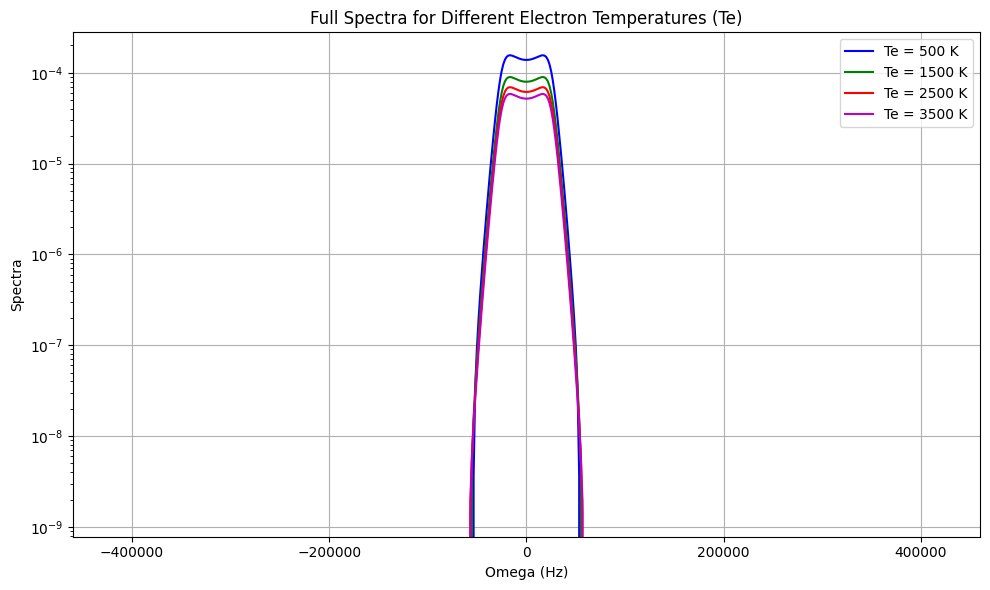

In [30]:
import matplotlib.pyplot as plt

#Sample Data
nu_i = 10 # Ion collision frequency in Hz
nu_e = 0.01 # Electron collision frequency in Hz
ni = ne = 2e11  # Ion and electron densities in m^-3
mi = 2.65686e-26  # Ion mass (atomic oxygen) in kg
m_e = 9.11e-31  # Electron mass [kg]
B = 3.6e-5 # Magnetic field strength in Tesla
theta = 60  # Scattering angle in degrees
Te_values = [500, 1500, 2500, 3500]  # Ion and electron temperatures in Kelvin

# Constants
epsilon_0 = 8.854187817e-12  # Vacuum permittivity [F/m]
kB = 1.380649e-23  # Boltzmann constant [J/K]
e = 1.602e-19  # Elementary charge [C]

n_terms = 2000

k_total, k_parallel, k_perpendicular = calculate_wavenumber_components(0.69719, theta)

spectra_list = []

for T in Te_values:
    Te = Ti = T
    
    vth_i = calculate_thermal_velocity(kB, Ti, mi)
    vth_e = calculate_thermal_velocity(kB, Te, m_e)
    
    Oc_i = calculate_cyclotron_frequency(1, e, B, mi)
    Oc_e = calculate_cyclotron_frequency(1, e, B, m_e)
    
    rho_i = calculate_average_gyroradius(vth_i, Oc_i)
    rho_e = calculate_average_gyroradius(vth_e, Oc_e)
    
    lambda_De = calculate_debye_length(Te, ne, epsilon_0, kB, e)
    lambda_Di = calculate_debye_length(Te, ni, epsilon_0, kB, e)
    
    alpha_e = calculate_alpha(k_total, lambda_De)
    alpha_i = calculate_alpha(k_total, lambda_Di)

    c = calculate_sound_speed(kB, Te, Ti, mi)
    
    omega_values = calculate_omega_values(k_total, c)
    
    U_i = calculate_collisional_term(nu_i, k_parallel, vth_i, k_perpendicular, rho_i, n_terms, omega_values, Oc_i)
    U_e = calculate_collisional_term(nu_e, k_parallel, vth_e, k_perpendicular, rho_e, n_terms, omega_values, Oc_e)

    M_i = calculate_modified_distribution(omega_values, k_parallel, k_perpendicular, vth_i, n_terms, rho_i, Oc_i, nu_i, U_i)
    M_e = calculate_modified_distribution(omega_values, k_parallel, k_perpendicular, vth_e, n_terms, rho_e, Oc_e, nu_e, U_e)
    
    chi_i = calculate_electric_susceptibility(omega_values, k_parallel, k_perpendicular, vth_i, n_terms, rho_i, Oc_i, nu_i, alpha_i, U_i, Ti, Ti)
    chi_e = calculate_electric_susceptibility(omega_values, k_parallel, k_perpendicular, vth_e, n_terms, rho_e, Oc_e, nu_e, alpha_e, U_e, Te, Te)
    
    spectra = calcSpectra(M_i, M_e, chi_i, chi_e)
    
    # Store spectra for plotting
    spectra_list.append(spectra)

# Set up a single plot for the full spectra
fig, ax = plt.subplots(figsize=(10, 6))

# Colors and labels
colors = ['b', 'g', 'r', 'm']
labels = [f'Te = {T} K' for T in Te_values]

# Plot Spectra
for i, spectra in enumerate(spectra_list):
    ax.plot(omega_values, spectra, color=colors[i], label=labels[i])

ax.set_xlabel('Omega (Hz)')
ax.set_ylabel('Spectra')
ax.set_title('Full Spectra for Different Electron Temperatures (Te)')
ax.legend()
ax.grid(True)
ax.set_yscale('log')  # Logarithmic y-axis

# Show the plot
plt.tight_layout()
plt.show()